In [1843]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import threading
import queue

from collections import defaultdict
warnings.filterwarnings("ignore")


In [1844]:
# Tratamento de dados para o problema

df_dados = pd.read_excel("./sample_data/dados.xlsx")

quantidade_itens = df_dados['Item'].nunique()
quantidade_caixas = df_dados['Caixa Id'].nunique()

itens = df_dados['Item'].unique().tolist()
caixas = df_dados['Caixa Id'].unique().tolist()

pecas_por_caixa = df_dados.groupby('Caixa Id')['Peças'].sum()
pecas_por_item = df_dados.groupby('Item')['Peças'].sum()
pecas_por_item = pecas_por_item.to_dict()

df_dados['Quantidade Total Peças'] = df_dados['Caixa Id'].map(pecas_por_caixa)

df_dados = df_dados.groupby('Caixa Id').agg(list)

def obter_valores_unicos(valores):
  return valores[0] if valores else None

df_dados['Quantidade Total Peças'] = df_dados['Quantidade Total Peças'].apply(obter_valores_unicos)

df_dados = df_dados.sort_values(by='Quantidade Total Peças', ascending=False)

In [1845]:
# Variáveis necessárias
np.random.seed(42)
capacidade_onda = 2000

In [1846]:
def calcula_ondas_ativas(solucao):
  ondas_ativas = []
  for id, onda in solucao.items():
    caixas_ativas = [i for i, valor in enumerate(onda) if valor == 1]
    if len(caixas_ativas) < 1:
      ondas_ativas.append(id)
  return ondas_ativas

In [1847]:
# Função Objetivo
def calcula_fo(s):
  return np.sum(s) / quantidade_itens

In [1848]:
def obter_alocacao_onda(onda):
  alocacao = [0]
  for id_caixa in range(0, quantidade_caixas):
    if onda[id_caixa] == 1:
      caixa = caixas[id_caixa]
      pecas_caixa = df_dados.loc[caixa]['Peças']
      alocacao.append(sum(pecas_caixa))
  return sum(alocacao)

In [1849]:
def calcula_alocacao_ondas(solucao):
  alocacao = dict()
  for id, onda in solucao.items():
    valor_alocacao = obter_alocacao_onda(onda)
    alocacao[id] = capacidade_onda - valor_alocacao
  return alocacao

In [1850]:
def define_matriz_solucao(solucao):
  ondas_ativas = calcula_ondas_ativas(solucao)
  n_ondas_ativas = len(ondas_ativas)

  z_kj = np.zeros((quantidade_itens, n_ondas_ativas))

  for id in ondas_ativas:
    for caixa in caixas:
      id_caixa = caixas.index(caixa)
      onda = solucao[id]

      if onda[id_caixa] == 0:
        continue

      itens_caixa = df_dados.loc[caixa]['Item']

      for item in itens_caixa:
        id_item = itens.index(item)
        z_kj[id_item][id] = 1
  return z_kj

In [1851]:
def swap(caixas_removidas, onda):
  for caixa in caixas_removidas:
    onda[caixa] = 1
  return onda

def seleciona_onda(id_i, solucao):
  n_ondas = list(solucao.keys())[-1]
  id_j = np.random.randint(0, n_ondas)
  while id_j == id_i:
    id_j = np.random.randint(0, n_ondas)
  return id_j

def seleciona_caixas(onda, quantidade):
  caixas_ativas = [i for i, valor in enumerate(onda) if valor == 1]
  if len(caixas_ativas) >= quantidade:
    return np.random.choice(caixas_ativas, size=quantidade, replace=False)
  return None

def desaloca_caixas(onda, caixas):
  for caixa in caixas:
    onda[caixa] = 0
  return onda

In [1852]:
# Solução Inicial: Construtiva gulosa, seleciona as caixas com mais itens distintos e aloca em uma onda.
# Quando a onda estiver sem capacidade para mais itens, ativa nova onda
def gera_solucao_inicial():
  ondas = dict()
  onda = [0] * quantidade_caixas
  ondas[0] = onda

  capacidade_ondas = dict()
  capacidade_ondas[0] = capacidade_onda

  for caixa in caixas:
    id_caixa = caixas.index(caixa)
    pecas_caixa = df_dados.loc[caixa]['Peças']
    for id, onda in list(ondas.items()):
      demanda_onda = capacidade_ondas[id]

      demanda_temporaria = demanda_onda - sum(pecas_caixa)
      if demanda_temporaria < 0:
        if id == list(ondas.keys())[-1]:
          nova_onda = [0] * quantidade_caixas
          novo_id = id + 1
          nova_onda[novo_id] = 1
          ondas[novo_id] = nova_onda
          capacidade_ondas[novo_id] = capacidade_onda
          break
        continue

      onda[id_caixa] = 1
      ondas[id] = onda
      capacidade_ondas[id] = demanda_temporaria
      break
  return ondas, capacidade_ondas

In [1853]:
# Vizinhança
def perturbacao_onda(solucao, n_vizinhanca, numero_ondas):
  id = np.random.randint(0, numero_ondas)

  onda = solucao[id]
  caixas_selecionadas = seleciona_caixas(onda, n_vizinhanca)

  if caixas_selecionadas is None:
    return None

  for id_caixa in caixas_selecionadas:
    onda[id_caixa] = 0

  solucao[id] = onda
  return id, solucao, caixas_selecionadas

def define_vizinhos(solucao, n_vizinhanca, numero_ondas, capacidade_ondas):
  solucao_vizinha = solucao
  capacidade_vizinha = capacidade_ondas
  resultado = perturbacao_onda(solucao_vizinha, n_vizinhanca,numero_ondas)

  if resultado is None:
    return None

  id_selecao, solucao_vizinha, caixas_restantes = resultado
  for id_caixa in caixas_restantes:
    caixa = caixas[id_caixa]
    pecas_caixa = df_dados.loc[caixa]['Peças']

    for id, onda in list(solucao_vizinha.items()):
      if id == id_selecao:
        continue

      demanda_onda = capacidade_vizinha[id]
      demanda_temporaria = demanda_onda - sum(pecas_caixa)

      if demanda_temporaria < 0:
        if id == list(solucao_vizinha.keys())[-1]:
          nova_onda = [0] * quantidade_caixas
          novo_id = id + 1
          nova_onda[novo_id] = 1
          solucao_vizinha[novo_id] = nova_onda
          capacidade_vizinha[novo_id] = capacidade_onda
          break
        continue

      onda[id_caixa] = 1
      solucao_vizinha[id] = onda
      capacidade_vizinha[id] = demanda_temporaria
      break
  return solucao_vizinha

In [1854]:
def gera_vizinho(solucao, vizinho):
  return obter_opt(solucao, vizinho)

def obter_opt(solucao, vizinho):
  numero_ondas = list(solucao.keys())[-1]
  numero_tentativas = numero_ondas

  while True:
    id_i = np.random.randint(0, numero_ondas)
    onda_i = solucao[id_i].copy()
    caixas_i = seleciona_caixas(onda_i, vizinho)

    id_j = seleciona_onda(id_i, solucao)
    onda_j = solucao[id_j].copy()
    caixas_j = seleciona_caixas(onda_j, 2)

    if caixas_i is not None and caixas_j is not None:
      onda_i = desaloca_caixas(onda_i, caixas_i)
      onda_j = desaloca_caixas(onda_j, caixas_j)
      break

    numero_tentativas -= 1
    if numero_tentativas <= 0:
      return None

  onda_i = swap(caixas_j, onda_i)
  onda_j = swap(caixas_i, onda_j)

  alocacao_j = obter_alocacao_onda(onda_j)
  alocacao_i = obter_alocacao_onda(onda_i)

  if alocacao_j <= capacidade_onda and alocacao_i <= capacidade_onda:
    solucao[id_i] = onda_i
    solucao[id_j] = onda_j
    return solucao

  onda = [0] * quantidade_caixas
  id = numero_ondas + 1

  for id_caixa in caixas_i:
    caixa = caixas[id_caixa]
    pecas_caixa = df_dados.loc[caixa]['Peças']
    qpecas = sum(pecas_caixa)

    if qpecas > capacidade_onda:
      print("Caixa acima do limite permitido. Ignorando...")
      break

    alocacao = obter_alocacao_onda(onda) + qpecas
    if alocacao > capacidade_onda:
      onda = [0] * quantidade_caixas
      id = numero_ondas + 1

    onda[id_caixa] = 1
    solucao[id] = onda
  return solucao

In [1855]:
# Busca Local
def busca_local(solucao_inicial, alocacao_ondas):
  solucao = solucao_inicial
  z_kj = define_matriz_solucao(solucao)

  iteracoes = 30
  parar_plato = 0

  vizinhos = []
  vizinho = 0

  while True:
    if vizinho >= quantidade_caixas:
      break

    numero_ondas = list(solucao_inicial.keys())[-1]
    solucao_vizinha = define_vizinhos(solucao, vizinho, numero_ondas, alocacao_ondas)

    if solucao_vizinha is not None:
      vizinhos.append(solucao_vizinha)

    vizinho += 1

  while iteracoes > 0:
    for solucao_vizinha in vizinhos:
      z_kj_vizinho = define_matriz_solucao(solucao_vizinha)

      atual = calcula_fo(z_kj)
      melhor = atual

      solucao_atual = z_kj_vizinho
      fo_vizinho = calcula_fo(solucao_atual)

      if fo_vizinho <= melhor:
        parar_plato = parar_plato + 1 if fo_vizinho == melhor else 0

        melhor = fo_vizinho
        solucao = solucao_vizinha
        z_kj = z_kj_vizinho

        alocacao_ondas = calcula_alocacao_ondas(solucao)

    iteracoes -= 1
    if melhor == atual and np.array_equal(z_kj_vizinho, z_kj) or parar_plato == 20:
      if parar_plato == 20: print('plato')
      break

  return solucao

In [1856]:
# VNS
def VNS():
  tempo_limite = 600
  solucao, alocacao_ondas = gera_solucao_inicial()
  vizinhancas = (quantidade_caixas / 2)
  vizinho = 1

  tempo_inicial = time.time()
  while True:
    time.sleep(1)
    tempo_decorrido = time.time() - tempo_inicial
    if tempo_decorrido >= tempo_limite:
      return solucao

    while vizinho <= vizinhancas:
      solucao_vizinha = gera_vizinho(solucao, vizinho)
      alocacao_ondas_vizinha = calcula_alocacao_ondas(solucao_vizinha)

      solucao_busca_local = busca_local(solucao_vizinha, alocacao_ondas_vizinha)

      if solucao_busca_local is None:
        iteracoes_sem_melhora += 1

      z_kj_vizinho = define_matriz_solucao(solucao_vizinha)
      z_kj_busca = define_matriz_solucao(solucao_busca_local)

      fo_vizinho = calcula_fo(z_kj_vizinho)
      fo_busca = calcula_fo(z_kj_busca)

      if fo_busca < fo_vizinho:
        solucao = solucao_busca_local
        alocacao_ondas = calcula_alocacao_ondas(solucao)
        vizinho = 1
      else:
        vizinho += 1
  return solucao


In [1857]:
def imprime_solucao(df_solucao):
  df_solucao.drop_duplicates(inplace=True)
  grouped_df = df_solucao.groupby('Onda')['Quantidade'].sum().reset_index()
  grouped_df = grouped_df.sort_values(by='Quantidade')

  cores = plt.cm.get_cmap('viridis', len(grouped_df))

  plt.figure(figsize=(10, 6))
  bars = plt.bar(grouped_df['Onda'], grouped_df['Quantidade'], color=cores(np.arange(len(grouped_df))))

  plt.xlabel('Onda')
  plt.ylabel('Quantidades')
  plt.title('Métrica de Ondas')
  plt.xticks(grouped_df['Onda'])

  sm = plt.cm.ScalarMappable(cmap=cores)
  sm.set_array([])
  cbar = plt.colorbar(sm)
  cbar.set_label('Quantidade')

  plt.tight_layout()
  plt.show()

In [1858]:
def exportar_solucao(df_solucao):
  excel_file = './sample_data/ondas.xlsx'
  df_solucao.to_excel(excel_file, index=False)

  print(f"Matriz salva com sucesso em '{excel_file}'.")

1.0001752376556396
12.182505369186401
13.18432903289795
14.185703992843628
15.186182737350464
16.18751335144043
17.18880295753479
18.19010043144226
19.191443920135498
20.19276261329651
21.19326615333557
22.194586515426636
23.19589376449585
24.197198152542114
25.198369026184082
26.199177980422974
27.200176239013672
28.201399564743042
29.20266056060791
30.203954458236694
31.20540499687195
32.206674575805664
33.20796728134155
34.209275007247925
35.210219621658325
36.21122646331787
37.212225914001465
38.21316647529602
39.214420795440674
40.21576929092407
41.21707773208618
42.218419313430786
43.21973633766174
44.22105407714844
45.22301006317139
46.22421741485596
47.22553014755249
48.22683572769165
49.22721481323242
50.22818350791931
51.22949528694153
52.23080778121948
53.23210859298706
54.233299255371094
55.23460650444031
56.235963106155396
57.237385988235474
58.23871970176697
59.23920798301697
60.24051308631897
61.24120759963989
62.242586612701416
63.243932485580444
64.24523401260376
65.24

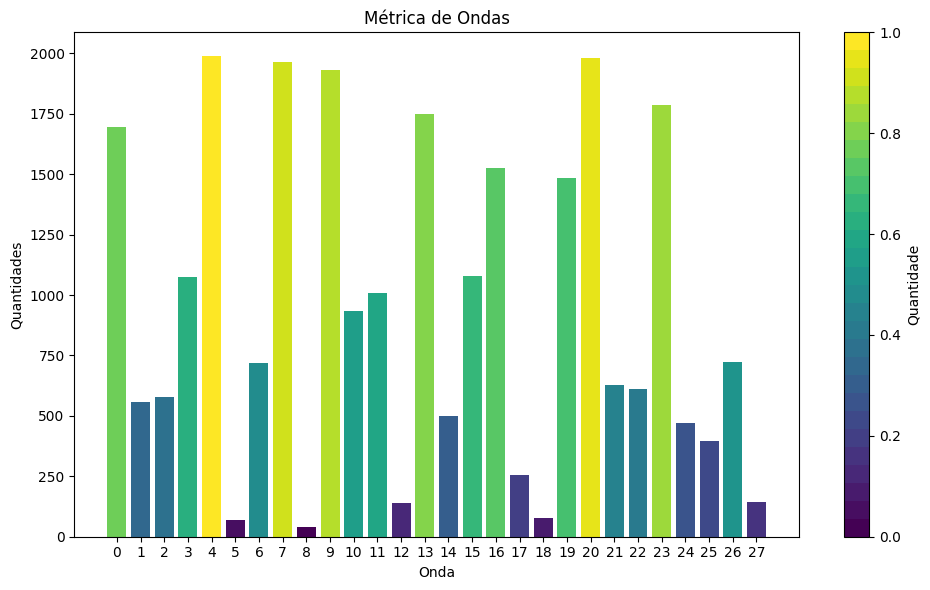

Matriz salva com sucesso em './sample_data/ondas.xlsx'.


In [1859]:
vns = VNS()
if not vns:
  print('Sem solução')

else:
  z_kj = define_matriz_solucao(vns)
  fo_solucao = calcula_fo(z_kj)

  print(f"FO encontrada: {fo_solucao}")

  df_solucao = pd.DataFrame(columns=['Onda', 'Item', 'Quantidade'])
  for id, onda in vns.items():
    for id_caixa in range(0, quantidade_caixas):
      if onda[id_caixa] == 0:
        continue

      caixa = caixas[id_caixa]

      itens_caixa = df_dados.loc[caixa]['Item']
      pecas_caixa = df_dados.loc[caixa]['Peças']
      for item, peca in zip(itens_caixa, pecas_caixa):
        row = {'Onda': id, 'Item': item, 'Quantidade': peca}
        row = pd.DataFrame([row])
        df_solucao = pd.concat([df_solucao, row], ignore_index=True)

  imprime_solucao(df_solucao)
  exportar_solucao(df_solucao)